# 1D CNN

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.utils.tensorboard import SummaryWriter

from torchinfo import summary

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

from tqdm import tqdm

In [3]:
DATA_PATH = "../data/filtered_df.csv"
SAVED_MODELS_PATH = "saved_models/"
RUNS_PATH = "runs/"

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

In [5]:
class TemperatureDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        super(TemperatureDataset, self).__init__()

        self.X = torch.from_numpy(X).type(torch.FloatTensor).to(DEVICE)
        self.y = torch.from_numpy(y).type(torch.LongTensor).to(DEVICE)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [6]:
df = pd.read_csv(DATA_PATH, index_col=False)
df = df.sample(frac=1)
df.reset_index(drop=True, inplace=True)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1432,1433,1434,1435,1436,1437,1438,1439,disease,disease_encoded
0,0.070542,0.066603,-0.024540,0.031063,0.010883,-0.009462,-0.040026,0.013276,0.011590,0.033470,...,-0.453165,-0.442173,-0.484539,-0.455936,-0.319981,-0.306396,-0.173097,-0.157362,dengue,0
1,-0.442717,-0.447170,-0.472113,-0.524862,-0.549047,-0.574217,-0.597002,-0.595214,-0.602310,-0.587725,...,-0.501442,-0.502091,-0.498524,-0.493322,-0.510359,-0.516447,-0.468571,-0.476863,non-tubercular bacterial infection,2
2,-0.378193,-0.420660,-0.482410,-0.571230,-0.630750,-0.690745,-0.747919,-0.777871,-0.817769,-0.836155,...,-0.545842,-0.550773,-0.551656,-0.551811,-0.574878,-0.585371,-0.541791,-0.556640,non-tubercular bacterial infection,2
3,-0.449017,-0.441264,-0.466737,-0.507130,-0.518813,-0.544285,-0.554192,-0.553093,-0.547142,-0.519073,...,-0.602167,-0.062855,-0.059663,-0.571766,-0.507522,-0.501939,-0.454121,-0.450743,dengue,0
4,-0.753149,-0.733287,-0.744690,-0.776226,-0.777201,-0.792130,-0.791499,-0.829692,-0.813205,-0.788606,...,0.738852,0.730265,0.721191,0.795023,0.781822,0.751838,0.759903,0.745348,dengue,0


In [7]:
X = df.drop("disease", axis=1)
X = X.drop("disease_encoded", axis=1)
y = df["disease_encoded"]

In [8]:
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.2, random_state=42)
train_data = train_data.to_numpy()
test_data = test_data.to_numpy()
train_labels = train_labels.to_numpy()
test_labels = test_labels.to_numpy()

In [9]:
train_dataset = TemperatureDataset(train_data, train_labels)
test_dataset = TemperatureDataset(test_data, test_labels)

In [10]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

In [11]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()

    self.conv_block = nn.Sequential(
        nn.Conv1d(1, 64, 3),
        nn.MaxPool1d(3),
        nn.Dropout(0.3),
        nn.BatchNorm1d(64)
    )

    self.dense = nn.Linear(30656, 4)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    num_samples, num_features = x.shape
    x = x.reshape(num_samples, 1, num_features)

    x = x.to(DEVICE)
    x = self.conv_block(x)
    x = x.reshape(num_samples, -1)

    return self.softmax(self.dense(x))

In [12]:
sample_x, sample_y = next(iter(train_loader))

## SGD

In [13]:
model = Model()
model = model.to(DEVICE)
model

Model(
  (conv_block): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,))
    (1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (2): Dropout(p=0.3, inplace=False)
    (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dense): Linear(in_features=30656, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

In [14]:
summary(model, input_data=sample_x)

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [8, 4]                    --
├─Sequential: 1-1                        [8, 64, 479]              --
│    └─Conv1d: 2-1                       [8, 64, 1438]             256
│    └─MaxPool1d: 2-2                    [8, 64, 479]              --
│    └─Dropout: 2-3                      [8, 64, 479]              --
│    └─BatchNorm1d: 2-4                  [8, 64, 479]              128
├─Linear: 1-2                            [8, 4]                    122,628
├─Softmax: 1-3                           [8, 4]                    --
Total params: 123,012
Trainable params: 123,012
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 3.93
Input size (MB): 0.05
Forward/backward pass size (MB): 7.85
Params size (MB): 0.49
Estimated Total Size (MB): 8.39

In [15]:
tb_board = RUNS_PATH + "1d_cnn_sgd"
writer = SummaryWriter(tb_board)

In [16]:
writer.add_graph(model, sample_x)

In [17]:
EPOCHS = 200

acc_list = []
f1_list = []
recall_list = []
precision_list = []

loss_list = []

In [18]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [19]:
for epoch in range(EPOCHS):
  model.train()
  running_loss = 0.0

  labels_list = []
  preds_list = []

  for (x, y) in train_loader:
    x, y = x.to(DEVICE), y.to(DEVICE)

    yhat = model(x)

    labels_list.extend(y.cpu())
    preds_list.extend(yhat.argmax(1).cpu())

    loss = loss_fn(yhat, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  avg_loss = running_loss / len(train_loader)
  loss_list.append(avg_loss)

  acc = accuracy_score(labels_list, preds_list)
  pre = precision_score(labels_list, preds_list, average='weighted', zero_division=0)
  rec = recall_score(labels_list, preds_list, average='weighted', zero_division=0)
  f1 = f1_score(labels_list, preds_list, average='weighted', zero_division=0)

  acc_list.append(acc)
  precision_list.append(pre)
  recall_list.append(rec)
  f1_list.append(f1)

  writer.add_scalar("Train/Loss", avg_loss, epoch)
  writer.add_scalar("Train/Accuracy", acc, epoch)
  writer.add_scalar("Train/Precision", pre, epoch)
  writer.add_scalar("Train/Recall", rec, epoch)
  writer.add_scalar("Train/F1", f1, epoch)

  print(f"Epoch: {epoch + 1} - Loss: {avg_loss} - Accuracy: {acc} - Precision: {pre} - Recall: {rec} - F1: {f1}")

Epoch: 1 - Loss: 1.4141719261805217 - Accuracy: 0.2608695652173913 - Precision: 0.27188921123853654 - Recall: 0.2608695652173913 - F1: 0.26139595767949586
Epoch: 2 - Loss: 1.3436542987823485 - Accuracy: 0.3652173913043478 - Precision: 0.3539732677029165 - Recall: 0.3652173913043478 - F1: 0.3576027849729673
Epoch: 3 - Loss: 1.2870837450027466 - Accuracy: 0.4434782608695652 - Precision: 0.46543030544224456 - Recall: 0.4434782608695652 - F1: 0.4461132300584491
Epoch: 4 - Loss: 1.277251382668813 - Accuracy: 0.4260869565217391 - Precision: 0.4871569497364163 - Recall: 0.4260869565217391 - F1: 0.4368671828469327
Epoch: 5 - Loss: 1.2600499749183656 - Accuracy: 0.48695652173913045 - Precision: 0.5228833123398341 - Recall: 0.48695652173913045 - F1: 0.49807101414678207
Epoch: 6 - Loss: 1.2270943601926168 - Accuracy: 0.4956521739130435 - Precision: 0.5161033017325923 - Recall: 0.4956521739130435 - F1: 0.4999593684145026
Epoch: 7 - Loss: 1.2216519355773925 - Accuracy: 0.5043478260869565 - Precisio

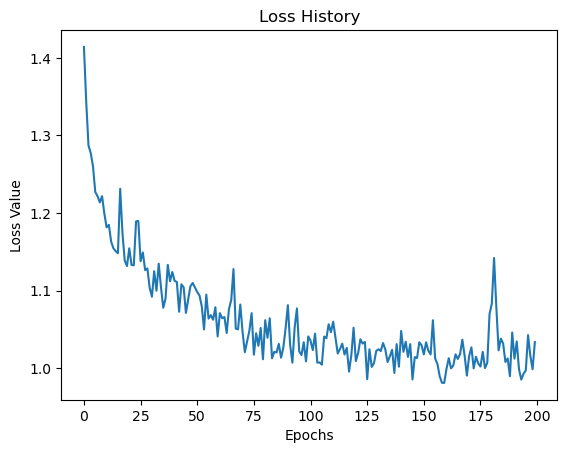

In [20]:
plt.title("Loss History")
plt.plot(range(EPOCHS), loss_list)
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.savefig("figures/training_loss_history_1d_cnn_sgd.pdf", bbox_inches="tight")
plt.show()

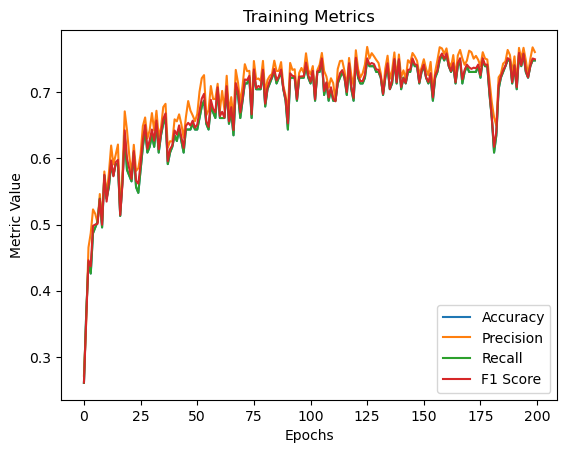

In [21]:
plt.title("Training Metrics")
plt.plot(range(EPOCHS), acc_list, label="Accuracy")
plt.plot(range(EPOCHS), precision_list, label="Precision")
plt.plot(range(EPOCHS), recall_list, label="Recall")
plt.plot(range(EPOCHS), f1_list, label="F1 Score")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Metric Value")
plt.savefig("figures/training_metrics_1d_cnn_sgd.pdf", bbox_inches="tight")
plt.show()

In [22]:
print(f"Mean Training Accuracy: {np.array(acc_list).mean()}")
print(f"Mean Training Precision: {np.array(precision_list).mean()}")
print(f"Mean Training Recall: {np.array(recall_list).mean()}")
print(f"Mean Training F1 Score: {np.array(f1_list).mean()}")

writer.add_scalar("Train/Mean Accuracy", np.array(acc_list).mean(), 0)
writer.add_scalar("Train/Mean Precision", np.array(precision_list).mean(), 0)
writer.add_scalar("Train/Mean Recall", np.array(recall_list).mean(), 0)
writer.add_scalar("Train/Mean F1 Score", np.array(f1_list).mean(), 0)

Mean Training Accuracy: 0.6797391304347826
Mean Training Precision: 0.6971027352416772
Mean Training Recall: 0.6797391304347826
Mean Training F1 Score: 0.6837828354995537


In [23]:
loss = 0.0
accuracy = 0.0
precision = 0.0
recall = 0.0
f1 = 0.0

In [24]:
model.eval()
with torch.no_grad():
  x = torch.tensor(test_data).type(torch.FloatTensor)
  y = torch.tensor(test_labels).type(torch.LongTensor)

  yhat = model(x)

  yhat = yhat.cpu()
  loss = loss_fn(yhat, y)

  yhat = yhat.argmax(1)
  accuracy = accuracy_score(yhat, y)
  precision = precision_score(yhat, y, average='weighted')
  recall = recall_score(yhat, y, average='weighted')
  f1 = f1_score(yhat, y, average='weighted')

In [25]:
print(f"Testing Loss: {loss}")
print(f"Testing Accuracy: {accuracy}")
print(f"Testing Precision: {precision}")
print(f"Testing Recall: {recall}")
print(f"Testing F1 Score: {f1}")

writer.add_scalar("Test/Loss", loss, 0)
writer.add_scalar("Test/Accuracy", accuracy, 0)
writer.add_scalar("Test/Precision", precision, 0)
writer.add_scalar("Test/Recall", recall, 0)
writer.add_scalar("Test/F1 Score", f1, 0)

Testing Loss: 1.3690919876098633
Testing Accuracy: 0.3448275862068966
Testing Precision: 0.34051724137931033
Testing Recall: 0.3448275862068966
Testing F1 Score: 0.33748320644872365


## Adam

In [26]:
model = Model()
model = model.to(DEVICE)
model

Model(
  (conv_block): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,))
    (1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (2): Dropout(p=0.3, inplace=False)
    (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dense): Linear(in_features=30656, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

In [27]:
summary(model, input_data=sample_x)

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [8, 4]                    --
├─Sequential: 1-1                        [8, 64, 479]              --
│    └─Conv1d: 2-1                       [8, 64, 1438]             256
│    └─MaxPool1d: 2-2                    [8, 64, 479]              --
│    └─Dropout: 2-3                      [8, 64, 479]              --
│    └─BatchNorm1d: 2-4                  [8, 64, 479]              128
├─Linear: 1-2                            [8, 4]                    122,628
├─Softmax: 1-3                           [8, 4]                    --
Total params: 123,012
Trainable params: 123,012
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 3.93
Input size (MB): 0.05
Forward/backward pass size (MB): 7.85
Params size (MB): 0.49
Estimated Total Size (MB): 8.39

In [28]:
tb_board = RUNS_PATH + "1d_cnn_adam"
writer = SummaryWriter(tb_board)

In [29]:
EPOCHS = 200

acc_list = []
f1_list = []
recall_list = []
precision_list = []

loss_list = []

In [30]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [31]:
for epoch in range(EPOCHS):
  model.train()
  running_loss = 0.0

  labels_list = []
  preds_list = []

  for (x, y) in train_loader:
    x, y = x.to(DEVICE), y.to(DEVICE)

    yhat = model(x)

    labels_list.extend(y.cpu())
    preds_list.extend(yhat.argmax(1).cpu())

    loss = loss_fn(yhat, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  avg_loss = running_loss / len(train_loader)
  loss_list.append(avg_loss)

  acc = accuracy_score(labels_list, preds_list)
  pre = precision_score(labels_list, preds_list, average='weighted', zero_division=0)
  rec = recall_score(labels_list, preds_list, average='weighted', zero_division=0)
  f1 = f1_score(labels_list, preds_list, average='weighted', zero_division=0)

  acc_list.append(acc)
  precision_list.append(pre)
  recall_list.append(rec)
  f1_list.append(f1)

  writer.add_scalar("Train/Loss", avg_loss, epoch)
  writer.add_scalar("Train/Accuracy", acc, epoch)
  writer.add_scalar("Train/Precision", pre, epoch)
  writer.add_scalar("Train/Recall", rec, epoch)
  writer.add_scalar("Train/F1", f1, epoch)

  print(f"Epoch: {epoch + 1} - Loss: {avg_loss} - Accuracy: {acc} - Precision: {pre} - Recall: {rec} - F1: {f1}")

Epoch: 1 - Loss: 1.4380183617273967 - Accuracy: 0.28695652173913044 - Precision: 0.2849480151228734 - Recall: 0.28695652173913044 - F1: 0.2789314409579819
Epoch: 2 - Loss: 1.4257402022679646 - Accuracy: 0.33043478260869563 - Precision: 0.32312388813776416 - Recall: 0.33043478260869563 - F1: 0.31944706429926195
Epoch: 3 - Loss: 1.3724656581878663 - Accuracy: 0.3652173913043478 - Precision: 0.3607086544600156 - Recall: 0.3652173913043478 - F1: 0.3545555297217702
Epoch: 4 - Loss: 1.3791588385899862 - Accuracy: 0.3565217391304348 - Precision: 0.3523880105401845 - Recall: 0.3565217391304348 - F1: 0.3453139364383742
Epoch: 5 - Loss: 1.3349931399027506 - Accuracy: 0.3826086956521739 - Precision: 0.3917099635531247 - Recall: 0.3826086956521739 - F1: 0.37937185960927694
Epoch: 6 - Loss: 1.3172439495722452 - Accuracy: 0.40869565217391307 - Precision: 0.40015166835187055 - Recall: 0.40869565217391307 - F1: 0.39534402095939114
Epoch: 7 - Loss: 1.3422384182612102 - Accuracy: 0.3826086956521739 - Pr

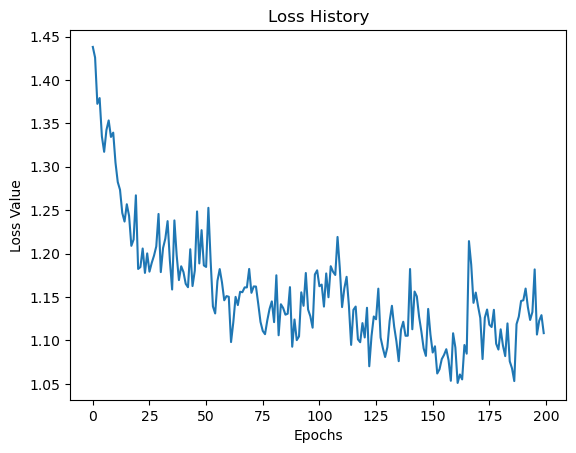

In [32]:
plt.title("Loss History")
plt.plot(range(EPOCHS), loss_list)
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.savefig("figures/training_loss_history_1d_cnn_adam.pdf", bbox_inches="tight")
plt.show()

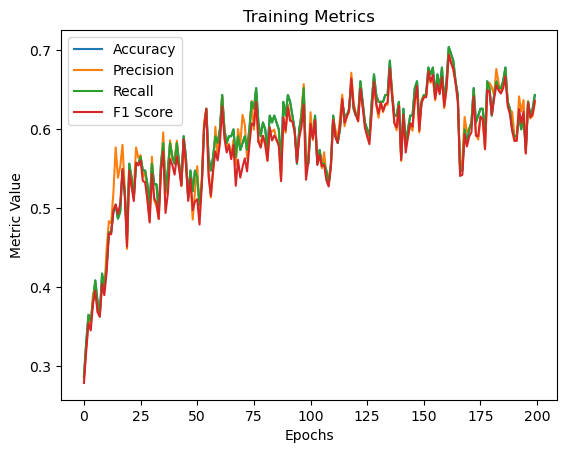

In [33]:
plt.title("Training Metrics")
plt.plot(range(EPOCHS), acc_list, label="Accuracy")
plt.plot(range(EPOCHS), precision_list, label="Precision")
plt.plot(range(EPOCHS), recall_list, label="Recall")
plt.plot(range(EPOCHS), f1_list, label="F1 Score")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Metric Value")
plt.savefig("figures/training_metrics_1d_cnn_adam.pdf", bbox_inches="tight")
plt.show()

In [34]:
print(f"Mean Training Accuracy: {np.array(acc_list).mean()}")
print(f"Mean Training Precision: {np.array(precision_list).mean()}")
print(f"Mean Training Recall: {np.array(recall_list).mean()}")
print(f"Mean Training F1 Score: {np.array(f1_list).mean()}")

writer.add_scalar("Train/Mean Accuracy", np.array(acc_list).mean(), 0)
writer.add_scalar("Train/Mean Precision", np.array(precision_list).mean(), 0)
writer.add_scalar("Train/Mean Recall", np.array(recall_list).mean(), 0)
writer.add_scalar("Train/Mean F1 Score", np.array(f1_list).mean(), 0)

Mean Training Accuracy: 0.5855217391304347
Mean Training Precision: 0.5824690415421568
Mean Training Recall: 0.5855217391304347
Mean Training F1 Score: 0.5751918193072919


In [35]:
loss = 0.0
accuracy = 0.0
precision = 0.0
recall = 0.0
f1 = 0.0

In [36]:
model.eval()
with torch.no_grad():
  x = torch.tensor(test_data).type(torch.FloatTensor)
  y = torch.tensor(test_labels).type(torch.LongTensor)

  yhat = model(x)

  yhat = yhat.cpu()
  loss = loss_fn(yhat, y)

  yhat = yhat.argmax(1)
  accuracy = accuracy_score(yhat, y)
  precision = precision_score(yhat, y, average='weighted', zero_division=0)
  recall = recall_score(yhat, y, average='weighted', zero_division=0)
  f1 = f1_score(yhat, y, average='weighted', zero_division=0)

In [37]:
print(f"Testing Loss: {loss}")
print(f"Testing Accuracy: {accuracy}")
print(f"Testing Precision: {precision}")
print(f"Testing Recall: {recall}")
print(f"Testing F1 Score: {f1}")

writer.add_scalar("Test/Loss", loss, 0)
writer.add_scalar("Test/Accuracy", accuracy, 0)
writer.add_scalar("Test/Precision", precision, 0)
writer.add_scalar("Test/Recall", recall, 0)
writer.add_scalar("Test/F1 Score", f1, 0)

Testing Loss: 1.3696033954620361
Testing Accuracy: 0.3793103448275862
Testing Precision: 0.3936781609195403
Testing Recall: 0.3793103448275862
Testing F1 Score: 0.36901030004478275
